# Linear RNN

This notebook contains both the training part (ca 5 min runtime on laptop without GPU) and the analysis, resulting in Fig 10.

In [1]:
import os, time
from copy import deepcopy
import numpy as np
import pickle
from tqdm import tqdm

# Pytorch
import torch
use_cuda = True
if torch.cuda.is_available() and use_cuda:
    device = torch.device('cuda')
    print("Use cuda.")
else:
    device = torch.device('cpu')
    print("Use cpu.")
to_dev = lambda arr: (torch.from_numpy(arr).to(device)
                       if type(arr) == np.ndarray else arr.to(device))
# Network
from rnn_model_dt_linear import RNN_Net
from helpers import copy_sd
# Data path
from specs import data_path

# Figures 
from specs import *
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

Use cpu.


In [2]:
# Training takes about 5 min.
run_sim = True

if run_sim:
    # Parameters
    rank = 2
    out_scale = 'large'
    z_target_0 = 1
    sigma_noise = 1
    # Correlation between in and out weights
    rho_sqrtN = -0.5
    # Correct the target by offsetting the initial loss?
    shift_target = False

    # Updated target
    z_0 = rho_sqrtN
    z_target = z_target_0 + z_0 * shift_target

    # Network size
    dim_hids = np.array([256])
    n_n = len(dim_hids)

    # First slow learning (lr/N), then fast (lr/1)
    lr0 = 0.002
    lr0_slow = lr0
    lr0_fast = lr0
    n_steps_slow = int(1e3)
    n_steps_fast = int(5e3)
    n_steps = n_steps_slow + n_steps_fast

    g = 0.0
    n_samples = 1
    n_mi = n_samples, n_n
    # Net
    dim_in = 1
    dim_out = 1
    batch_size = 32
    n_layers = 2
    bias = False
    train_in = False
    train_hid = True
    train_out = False
    train_layers = [train_in, train_hid, train_out]
    nonlin = torch.nn.Identity()
    gaussian_init = True
    h_0_std = 0.
    dt = 0.2
    rec_step_dt = 1
    noise_hid_std = np.sqrt(2) * sigma_noise

    # Task
    t_max = 20
    ts = np.arange(0, t_max, dt)
    n_t = len(ts)
    input_amp = 1
    target_amp = z_target
    t_min_target = 15
    input = input_amp * torch.ones((batch_size, n_t, dim_in))
    target = target_amp * torch.ones((batch_size, n_t, dim_out))
    mask = torch.zeros((batch_size, n_t, dim_out), dtype=bool)
    mask[:, ts >= t_min_target] = True
    # # Plot task
    # plt.plot(ts, input[0, :, 0])
    # plt.plot(ts[mask[0, :, 0]], target[0, :, 0][mask[0, :, 0]])
    task = input, target, mask
    input, target, mask = [to_dev(a) for a in task]

    # Loss
    loss_crit = torch.nn.MSELoss()

    # Results arrays
    steps = np.arange(n_steps) - n_steps_slow
    steps_slow = np.arange(n_steps_slow)
    steps_slow_plt = steps_slow - n_steps_slow
    steps_fast = np.arange(n_steps_fast)
    loss_all = np.zeros((*n_mi, n_steps))
    output_all = np.zeros((*n_mi, n_steps, batch_size, n_t, dim_out))
    # More specific
    loss_bias = np.zeros((*n_mi, n_steps))
    loss_var = np.zeros((*n_mi, n_steps))
    norm_dx_sim = np.zeros((*n_mi, n_steps))
    M_all = np.zeros((*n_mi, n_steps, rank, rank))
    t_min_avg = 10
    n_t_avg = int(t_min_avg / (dt * rec_step_dt))
    n_if = 2
    sd_if_all = np.zeros((n_if, *n_mi), dtype=object)

    for mi in np.ndindex(n_mi):
        i_s, i_n = mi
        dim_hid = dim_hids[i_n]

        # Size-dependent parameters
        rho = rho_sqrtN / np.sqrt(dim_hid)
        if out_scale == 'large':
            sigma_out = 1 / np.sqrt(dim_hid)
        else:
            sigma_out = 1 / dim_hid

        # Weights
        W_0 = g / np.sqrt(dim_hid) * torch.randn(dim_hid, dim_hid)
        w_io = torch.randn(dim_hid, 2)
        w_io = torch.linalg.qr(w_io)[0]
        w_out = w_io[:, :dim_out].T
        w_in = rho * w_io[:, :dim_out] + np.sqrt(1 - rho**2) * w_io[:, dim_out:]
        # Scale
        w_out *= sigma_out * np.sqrt(dim_hid)
        w_in *= np.sqrt(dim_hid)

        # Network
        net = RNN_Net(dim_in, dim_hid, dim_out, n_layers, nonlin, bias, out_scale, g, gaussian_init, 
                      dt, rec_step_dt, train_layers)
        net.to(device)
        W_0 = W_0.to(device)
        w_out = w_out.to(device)
        w_in = w_in.to(device)
        w_io = w_io.to(device)
        with torch.no_grad():
            net.rnn.weight_hh_l0[:] = W_0.clone()
            net.rnn.weight_ih_l0[:] = w_in.clone()
            net.decoder.weight[:] = w_out.clone()
        h_0 = h_0_std * torch.randn((n_layers - 1, 1, dim_hid), device=device)
        h_0 = torch.tile(h_0, (1, batch_size, 1))


        # Save before training
        sd_if_all[0][mi]= copy_sd(net.state_dict)
        with torch.no_grad():
            output, hids = net.forward_hid(input, h_0, noise_hid_std)
            last_state_init = hids[0, :, n_t_avg:].mean((0, 1))

        # Slow learning: warmup
        # Learning in two phses
        for i_phase in range(2):
            lr_i = [lr0_slow / dim_hid, lr0_fast][i_phase]
            n_steps_i = [n_steps_slow, n_steps_fast][i_phase]
            opt = torch.optim.SGD(net.parameters(), lr=lr_i)
            for step_i in tqdm(range(n_steps_i)):
                if i_phase == 0:
                    step = step_i
                elif i_phase == 1:
                    step = step_i + n_steps_slow
                # Update
                opt.zero_grad()
                output, hids = net.forward_hid(input, h_0, noise_hid_std)

                loss = loss_crit(output[mask], target[mask])
                loss.backward()
                opt.step()
                # Save
                loss_all[mi][step] = loss.item()
                output_all[mi][step] = output.detach().cpu().numpy()

                # Loss decomposition
                with torch.no_grad():
                    z_mean = output.mean(0, keepdims=True)
                    dz = output - z_mean
                    loss_bias[mi][step] = loss_crit(z_mean[mask[:1]], target[:1][mask[:1]])
                    loss_var[mi][step] = loss_crit(dz, 0*target)
                    # Norm of state changes
                    last_state = hids[0, :, n_t_avg:].mean((0, 1))
                    norm_dx_sim[mi][step] = torch.linalg.norm(last_state - last_state_init).item()

                    # Save weight projection
                    dW = net.rnn.weight_hh_l0.detach().clone() - W_0
                    M_all[mi][step] = (w_io.T @ dW @ w_io).cpu()

        # Save after training
        sd_if_all[1][mi] = copy_sd(net.state_dict)
    input, target, mask = [a.cpu() for a in task]


    res_dict = {
        "rank": rank, "out_scale": out_scale, "z_target_0": z_target_0, "sigma_noise": sigma_noise, 
        "rho_sqrtN": rho_sqrtN, "shift_target": shift_target, "z_0": z_0, "z_target": z_target, 
        "dim_hids": dim_hids, "n_n": n_n, "lr0": lr0, "lr0_slow": lr0_slow, "lr0_fast": lr0_fast, 
        "n_steps_slow": n_steps_slow, "n_steps_fast": n_steps_fast, "n_steps": n_steps, "g": g, 
        "n_samples": n_samples, "n_mi": n_mi, "dim_in": dim_in, "dim_out": dim_out, "batch_size": batch_size, 
        "n_layers": n_layers, "bias": bias, "train_in": train_in, "train_hid": train_hid, 
        "train_out": train_out, "train_layers": train_layers, "nonlin": nonlin, 
        "gaussian_init": gaussian_init, "h_0_std": h_0_std, "dt": dt, "rec_step_dt": rec_step_dt, 
        "noise_hid_std": noise_hid_std, "t_max": t_max, "ts": ts, "n_t": n_t, "input_amp": input_amp, 
        "target_amp": target_amp, "t_min_target": t_min_target, "input": input, "target": target, 
        "mask": mask, "task": task, "steps": steps, "steps_slow": steps_slow, "steps_slow_plt": steps_slow_plt, 
        "steps_fast": steps_fast, "loss_all": loss_all, "output_all": output_all, "loss_bias": loss_bias, 
        "loss_var": loss_var, "norm_dx_sim": norm_dx_sim, "M_all": M_all, "t_min_avg": t_min_avg, "n_t_avg": n_t_avg, 
        "w_io": w_io, "w_in": w_in, "w_out": w_out, 
        "sd_if_all": sd_if_all,
    }
    file_name = "linear_rnn_noisy"
    file_name = file_name.replace(".", "_") + ".pkl"
    data_file = os.path.join(data_path, file_name)
    with open(data_file, 'wb') as handle:
        pickle.dump(res_dict, handle)
    print("Saved data to %s" %data_file)

else:
    data_file = '../data/linear_rnn_noisy.pkl'
    with open(data_file, 'rb') as handle:
        variables = pickle.load(handle)
    print("Added to global:")
    for key, var in variables.items():
        print(' ', key)
        globals()[key] = var

Added to global:
  rank
  out_scale
  z_target_0
  sigma_noise
  rho_sqrtN
  shift_target
  z_0
  z_target
  dim_hids
  n_n
  lr0
  lr0_slow
  lr0_fast
  n_steps_slow
  n_steps_fast
  n_steps
  g
  n_samples
  n_mi
  dim_in
  dim_out
  batch_size
  n_layers
  bias
  train_in
  train_hid
  train_out
  train_layers
  nonlin
  gaussian_init
  h_0_std
  dt
  rec_step_dt
  noise_hid_std
  t_max
  ts
  n_t
  input_amp
  target_amp
  t_min_target
  input
  target
  mask
  task
  steps
  steps_slow
  steps_slow_plt
  steps_fast
  loss_all
  output_all
  loss_bias
  loss_var
  norm_dx_sim
  M_all
  t_min_avg
  n_t_avg
  w_io
  w_in
  w_out
  sd_if_all


In [3]:
# Eigenvalues of M
ew = np.linalg.eigvals(M_all)

# Norm of state changes
B = np.eye(rank) - M_all
Ux = np.linalg.inv(B) @ (w_io.T @ w_in[:, 0]).numpy()
Ux0 = (w_io.T @ w_in[:, 0]).numpy()
Udx = Ux - Ux0
norm_x = np.linalg.norm(Ux, axis=-1)
norm_dx = np.linalg.norm(Udx, axis=-1)

In [4]:
# Split fast and slow
loss_all_slow = loss_all[:, :, :n_steps_slow]
loss_all_fast = loss_all[:, :, n_steps_slow:]
loss_bias_slow = loss_bias[:, :, :n_steps_slow]
loss_bias_fast = loss_bias[:, :, n_steps_slow:]
loss_var_slow = loss_var[:, :, :n_steps_slow]
loss_var_fast = loss_var[:, :, n_steps_slow:]
M_slow = M_all[:, :, :n_steps_slow]
M_fast = M_all[:, :, n_steps_slow:]
M_slow = M_all[:, :, :n_steps_slow]
M_fast = M_all[:, :, n_steps_slow:]
norm_dx_slow = norm_dx[:, :, :n_steps_slow]
norm_dx_fast = norm_dx[:, :, n_steps_slow:]



In [5]:
# Theory 

# Slow learning rate
b_1_th_slow = (1 - np.exp(-2 * lr0_slow * steps_slow)) * (z_target - rho_sqrtN)
M_0_th_slow = np.zeros((n_steps_slow, rank, rank))
M_1_th_slow = np.zeros((n_steps_slow, rank, rank))
M_1_th_slow[:, 0, 1] = b_1_th_slow
loss_bias_th_slow = np.exp(-4 * lr0_slow * steps_slow) * (z_target - rho_sqrtN)**2
loss_var_th_slow = sigma_noise**2 + 0 * steps_slow
norm_dx_th_slow = b_1_th_slow

# Fast learning rate
a_0_th_fast = 1 - (3 * sigma_noise**2 * lr0_fast * steps_fast + 1)**(1/3)
b_1_th_fast = z_target * (1 - a_0_th_fast) - rho_sqrtN
M_0_th_fast = np.zeros((n_steps_fast, rank, rank))
M_0_th_fast[:, 0, 0] = a_0_th_fast
M_1_th_fast = np.zeros((n_steps_fast, rank, rank))
M_1_th_fast[:, 0, 1] = b_1_th_fast
loss_bias_th_fast = 0 * steps_fast
loss_var_th_fast = sigma_noise**2 * 1 / (1 * (1 - a_0_th_fast))
norm_dx_th_fast = z_target - rho_sqrtN + 0 * steps_fast

# # Eigenvalue
# ax = axes[1, i_c]
# for i in range(rank):
#     c=colors[i]
#     lbl = r"$\lambda_%s$" %"-+"[i]
#     ax.plot(steps_fast, ew[mi][:, i], c=c, label=lbl)
# ax.axhline(0, c=c_leg, zorder=-1)
# leg = ax.legend(loc=3, ncol=1, labelspacing=0.3, handlelength=0.7, 
#                 handletextpad=0.7, columnspacing=0.5, frameon=True)

Save figure to ../figures/fig_10_noisy_linear_learning.both


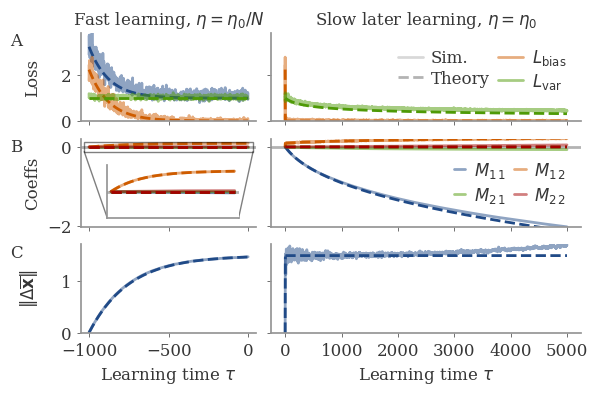

In [6]:
# One plot for slow and fast, respectively
n_cols = 2
n_rows = 3
fig = plt.figure(figsize=(2.5 * n_cols, 1. * n_rows))
# axes = subplots(fig, n_rows, n_cols, sharex='col', sharey='row')
axes = np.zeros((n_rows, n_cols), dtype=object)
gs0 = GridSpec(n_rows, 1)
gs0.update(left=0., right=0.35, bottom=0, top=1)
axes[:, 0] = [plt.subplot(gs0[i, 0]) for i in range(n_rows)]
gs0 = GridSpec(n_rows, 1)
gs0.update(left=0.38, right=1., bottom=0, top=1)
axes[:, 1] = [plt.subplot(gs0[i, 0]) for i in range(n_rows)]

i_s = 0
i_n = 0
mi = i_s, i_n
dim_hid = dim_hids[i_n]

ls_num = '-'
lw_num = 2
alpha_num = 0.5
ls_th = '--'
lw_th = 2
alpha_th = 1.


for i_c in range(2):
    i_sf = i_c
    steps_i = [steps_slow_plt, steps_fast][i_sf]
    loss_all_i = [loss_all_slow, loss_all_fast][i_sf][mi]
    loss_bias_i = [loss_bias_slow, loss_bias_fast][i_sf][mi]
    loss_bias_th = [loss_bias_th_slow, loss_bias_th_fast][i_sf]
    loss_var_i = [loss_var_slow, loss_var_fast][i_sf][mi]
    loss_var_th = [loss_var_th_slow, loss_var_th_fast][i_sf]
    M_i = [M_slow, M_fast][i_sf][mi]
    M_0_th = [M_0_th_slow, M_0_th_fast][i_sf]
    M_1_th = [M_1_th_slow, M_1_th_fast][i_sf]
    M_th = M_0_th + M_1_th / np.sqrt(dim_hid)
    norm_dx_i = [norm_dx_slow, norm_dx_fast][i_sf][mi]
    norm_dx_th = [norm_dx_th_slow, norm_dx_th_fast][i_sf]
   
    # Loss
    ax = axes[0, i_c]
    # Labels for  theory, sim
    ax.plot(0, 0, ls=ls_num, lw=lw_num, alpha=alpha_num, c=c_leg, label="Sim.")
    ax.plot(0, 0, ls=ls_th, lw=lw_th, alpha=alpha_th, c=c_leg, label="Theory")
    ax.plot(0, 0, alpha=0, label=' ')
    # Different losses
    if i_sf == 0:
        c = colors[0]
        ax.plot(steps_i, loss_all_i, ls_num, lw=lw_num, c=c, label=r"$L$", alpha=alpha_num)
        ax.plot(steps_i, loss_bias_th + loss_var_th, ls_th, lw=lw_th, c=c, alpha=alpha_th)
    c = colors[1]
    ax.plot(steps_i, loss_bias_i, ls_num, lw=lw_num, c=c, label=r"$L_\mathrm{bias}$", alpha=alpha_num)
    ax.plot(steps_i, loss_bias_th, ls_th, lw=lw_th, c=c, alpha=alpha_th)
    c = colors[2]
    ax.plot(steps_i, loss_var_i, ls_num, lw=lw_num, c=c, label=r"$L_\mathrm{var}$", alpha=alpha_num)
    ax.plot(steps_i, loss_var_th, ls_th, lw=lw_th, c=c, alpha=alpha_th)
    ax.set_ylim(0, loss_all.max())
    if i_c == 0:
        ax.set_ylabel("Loss")
    else:
        ax.set_yticklabels([])
    if i_c == 1:
        leg = ax.legend(loc=1, ncol=2, labelspacing=0.2, handlelength=1.5, 
                        handletextpad=0.5, columnspacing=0.5, frameon=False, 
              # bbox_to_anchor=(1.02, 1.3)
                       )
    ax.set_xticklabels([])

    # Entry b 
    ax = axes[1, i_c]
    for j, i in np.ndindex(rank, rank):
        k = rank * i + j
        c=colors[k]
        lbl = r"$M_{%d\,%d}$" % (i+1, j+1)
        ax.plot(steps_i, M_i[:, i, j], ls_num, lw=lw_num, c=c, label=lbl, alpha=alpha_num)
        ax.plot(steps_i, M_th[:, i, j], ls_th, lw=lw_th, c=c, alpha=alpha_th)
    ax.axhline(0, c=c_leg, zorder=-1)
    ax.set_ylim(M_all.min(), M_all.max())
    if i_c == 0:
        ax.set_ylabel("Coeffs")
    else:
        ax.set_yticklabels([])
    if i_c == 1:
        leg = ax.legend(loc=5, ncol=2, labelspacing=0.3, handlelength=0.7, 
                        handletextpad=0.5, columnspacing=0.5, frameon=False)
    ax.set_xticklabels([])
    # Inset
    if i_sf == 0:
        axins = ax.inset_axes([0.15, 0.1, 0.75, 0.6])
        for j, i in np.ndindex(rank, rank):
            k = rank * i + j
            c=colors[k]
            axins.plot(steps_i, M_i[:, i, j], ls_num, lw=lw_num, c=c, alpha=alpha_num)
            axins.plot(steps_i, M_th[:, i, j], ls_th, lw=lw_th, c=c, alpha=alpha_th)
        axins.axhline(0, c=c_leg, zorder=-1)
        ymax_ins = M_slow.max() * 1.3
        x1, x2, y1, y2 = -1030, 30, -ymax_ins, ymax_ins
        axins.set_xlim(x1, x2)
        axins.set_ylim(y1, y2)
        axins.set_yticklabels('')
        axins.set_xticklabels('')
        axins.set_xticks([])
        axins.set_yticks([])
        ax.indicate_inset_zoom(axins, edgecolor="black")
        # # Plot scale
        # y = 1/np.sqrt(dim_hid)
        # axins.plot([-1]*2, [0, y], '-', lw=2, c='0.4')
        # axins.text(0, 0, r"$\frac{1}{\sqrt{N}}$", ha='left', va='bottom')

    # Norm of state changes
    ax = axes[2, i_c]
    c=colors[0]
    ax.plot(steps_i, norm_dx_i, ls_num, lw=lw_num, c=c, alpha=alpha_num)
    ax.plot(steps_i, norm_dx_th, ls_th, lw=lw_th, c=c, alpha=alpha_th)
    ax.set_ylim(0, norm_dx.max())
    if i_c == 0:
        ax.set_ylabel(r"$\|\Delta \overline{\mathbf{x}}\|$")
    else:
        ax.set_yticklabels([])
        
    ### Show the fast dynamics in the slow plot
    if i_sf == 0:
        ax = axes[0, 1]
        c = colors[1]
        steps_f = steps_i / dim_hid
        ax.plot(steps_f, loss_bias_i, ls_num, lw=lw_num, c=c,alpha=alpha_num)
        ax.plot(steps_f, loss_bias_th, ls_th, lw=lw_th, c=c, alpha=alpha_th)
        c = colors[2]
        ax.plot(steps_f, loss_var_i, ls_num, lw=lw_num, c=c, alpha=alpha_num)
        ax.plot(steps_f, loss_var_th, ls_th, lw=lw_th, c=c, alpha=alpha_th)
        ax = axes[1, 1]
        for j, i in np.ndindex(rank, rank):
            k = rank * i + j
            c=colors[k]
            ax.plot(steps_f, M_i[:, i, j], ls_num, lw=lw_num, c=c, alpha=alpha_num)
            ax.plot(steps_f, M_th[:, i, j], ls_th, lw=lw_th, c=c, alpha=alpha_th)
        ax = axes[2, 1]
        c=colors[0]
        ax.plot(steps_f, norm_dx_i, ls_num, lw=lw_num, c=c, alpha=alpha_num)
        ax.plot(steps_f, norm_dx_th, ls_th, lw=lw_th, c=c, alpha=alpha_th)
    

    # Polish
    ax = axes[-1, i_c]
    ax.set_xlabel(r"Learning time $\tau$")
    # Title
    ax = axes[0, i_c]
    lbl = [
        r"Fast learning, $\eta = \eta_0 / N$", 
        r"Slow later learning, $\eta = \eta_0$", 
            ][i_sf]
    ax.set_title(lbl)
    
    

# Label plots
for i in range(3):
    ax = fig.axes[i]
    xpos = -0.37
    ypos = 1.0
    ax.text(xpos, ypos, flbs[i], fontsize=fs, ha='center', va='top', transform=ax.transAxes)
    
fig.align_ylabels()

# Save figure
fig_name = "fig_10_noisy_linear_learning"
saving_fig(fig, figure_path, fig_name, data_type='both')